In [1]:
# Dependencies
!pip install -q monai nibabel matplotlib scikit-learn
import torch, os, random, numpy as np, nibabel as nib, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.metrics import DiceMetric

random.seed(42); np.random.seed(42); torch.manual_seed(42)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using MPS (Apple Silicon GPU)


In [2]:
# Dataset
root_dir = "./data/BraTS2021_Training_Data"

class BraTS2DFLAIR(Dataset):
    def __init__(self, root_dir, case_list, bg_keep_prob=0.15):
        self.root_dir = root_dir
        self.case_list = case_list
        self.bg_keep_prob = bg_keep_prob
        
        # preload volumes
        self.data = []
        print(f"Loading {len(case_list)} cases…")
        
        for case in case_list:
            seg_path   = os.path.join(root_dir, case, f"{case}_seg.nii.gz")
            flair_path = os.path.join(root_dir, case, f"{case}_flair.nii.gz")

            flair = nib.load(flair_path).get_fdata().astype(np.float32)
            seg   = nib.load(seg_path).get_fdata().astype(np.float32)

            mask = (seg > 0).astype(np.float32)

            self.data.append((flair, mask))

        # slice indexing
        print("Building slice index…")
        self.indices = []
        for case_idx, (_, mask) in enumerate(self.data):
            for z in range(mask.shape[2]):
                if mask[:, :, z].any() or random.random() < bg_keep_prob:
                    self.indices.append((case_idx, z))

        print(f"Total indexed slices: {len(self.indices)}")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        case_idx, z = self.indices[idx]
        flair, mask = self.data[case_idx]

        img  = flair[:, :, z]
        m    = mask[:, :, z]

        img = (img - img.mean()) / (img.std() + 1e-8)

        img = torch.tensor(img[None], dtype=torch.float32)
        m   = torch.tensor(m[None], dtype=torch.float32)
        return img, m


# Patient-wise split
all_cases = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f)) and not f.startswith(".")]
random.shuffle(all_cases)
limited_cases = all_cases[:500]

split_idx = int(0.90 * len(limited_cases))
train_cases, val_cases = limited_cases[:split_idx], limited_cases[split_idx:]

print(f"Total patients: {len(all_cases)}")
print(f"Train patients: {len(train_cases)} | Val patients: {len(val_cases)}")

train_ds = BraTS2DFLAIR(root_dir, train_cases, bg_keep_prob=0.15)
val_ds   = BraTS2DFLAIR(root_dir, val_cases,   bg_keep_prob=0.15)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

Total patients: 1251
Train patients: 450 | Val patients: 50
Loading 450 cases…
Building slice index…
Total indexed slices: 34864
Loading 50 cases…
Building slice index…
Total indexed slices: 4133


In [3]:
# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using:", device)

torch.set_float32_matmul_precision("high")

# Model
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

criterion = DiceLoss(sigmoid=True)

# Move to device
model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


Using: mps


In [4]:
# Training (20 epochs)
n_epochs = 20
best_dice = 0.0
history = {
    "train_loss": [],
    "val_loss": [],   
    "val_dice": []
}

dice_metric = DiceMetric(include_background=True, reduction="mean")

for epoch in range(1, n_epochs + 1):
    # Training 
    model.train()
    epoch_train_loss = 0.0
    for img, mask in train_loader:
        img, mask = img.to(device), mask.to(device)
        
        pred = model(img)
        loss = criterion(pred, mask)  
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    scheduler.step()

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    dice_metric.reset()
    
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            
            pred = model(img)
            loss = criterion(pred, mask)  
            epoch_val_loss += loss.item()
            
            # For Dice: apply activation (sigmoid for multi-label, softmax for multi-class)
            pred_act = torch.sigmoid(pred)  # Use softmax if using one-hot + CE
            dice_metric(pred_act, mask)

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_dice = dice_metric.aggregate().item()

    # Logging & Saving 
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["val_dice"].append(val_dice)

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "brats2021_flair_2d_best.pth")

    print(f"Epoch {epoch:02d}/20 | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Dice: {val_dice:.4f} | "
          f"Best Dice: {best_dice:.4f}")

print(f"\nTraining completed. Best validation Dice: {best_dice:.4f}")

Epoch 01/20 | Train Loss: 0.7109 | Val Loss: 0.4125 | Val Dice: 0.7142 | Best Dice: 0.7142
Epoch 02/20 | Train Loss: 0.3757 | Val Loss: 0.3596 | Val Dice: 0.7642 | Best Dice: 0.7642
Epoch 03/20 | Train Loss: 0.3485 | Val Loss: 0.3469 | Val Dice: 0.7399 | Best Dice: 0.7642
Epoch 04/20 | Train Loss: 0.3366 | Val Loss: 0.3363 | Val Dice: 0.7737 | Best Dice: 0.7737
Epoch 05/20 | Train Loss: 0.3270 | Val Loss: 0.3290 | Val Dice: 0.7886 | Best Dice: 0.7886
Epoch 06/20 | Train Loss: 0.3174 | Val Loss: 0.3268 | Val Dice: 0.7960 | Best Dice: 0.7960
Epoch 07/20 | Train Loss: 0.3109 | Val Loss: 0.3244 | Val Dice: 0.8082 | Best Dice: 0.8082
Epoch 08/20 | Train Loss: 0.3040 | Val Loss: 0.3261 | Val Dice: 0.7943 | Best Dice: 0.8082
Epoch 09/20 | Train Loss: 0.3005 | Val Loss: 0.3235 | Val Dice: 0.8036 | Best Dice: 0.8082
Epoch 10/20 | Train Loss: 0.2767 | Val Loss: 0.2322 | Val Dice: 0.7430 | Best Dice: 0.8082
Epoch 11/20 | Train Loss: 0.2356 | Val Loss: 0.2459 | Val Dice: 0.7561 | Best Dice: 0.8082

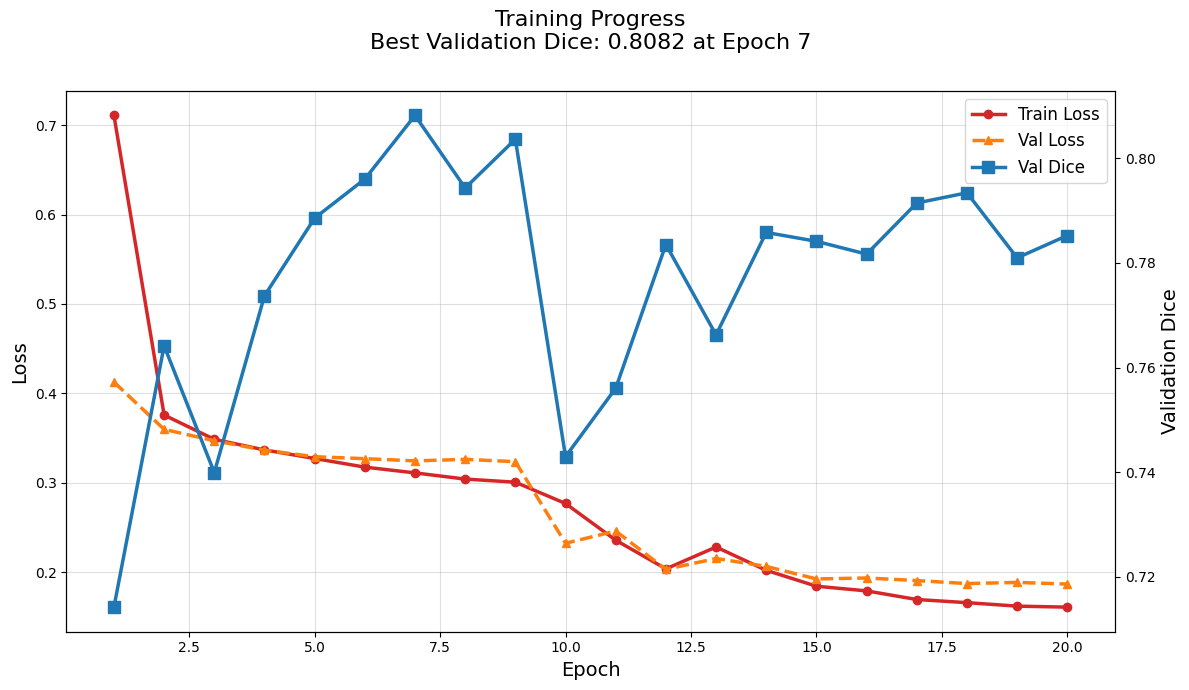

In [6]:
import matplotlib.pyplot as plt

# Extract data from history (after training)
epochs = list(range(1, len(history["train_loss"]) + 1))

best_dice = max(history["val_dice"])
best_epoch = history["val_dice"].index(best_dice) + 1

# Single plot with dual axes
fig, ax1 = plt.subplots(figsize=(12, 7))

# Losses on left y-axis
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.plot(epochs, history["train_loss"], 'o-', color='tab:red', linewidth=2.5, label='Train Loss')
ax1.plot(epochs, history["val_loss"], '^--', color='tab:orange', linewidth=2.5, label='Val Loss')
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.4)

# Validation Dice on right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Dice', fontsize=14)
ax2.plot(epochs, history["val_dice"], 's-', color='tab:blue', linewidth=2.5, markersize=8, label='Val Dice')
ax2.tick_params(axis='y')

# Title and combined legend
plt.title(f'Training Progress\n'
          f'Best Validation Dice: {best_dice:.4f} at Epoch {best_epoch}',
          fontsize=16, pad=30)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=12)

fig.tight_layout()
plt.show()

Dataset Statistics
Number of 3D cases used: 500
Total 2D slices: 38997
Train slices: 34864, Validation slices: 4133
Slices with tumor: 32148 (82.4%)
Background-only slices: 6849 (17.6%)


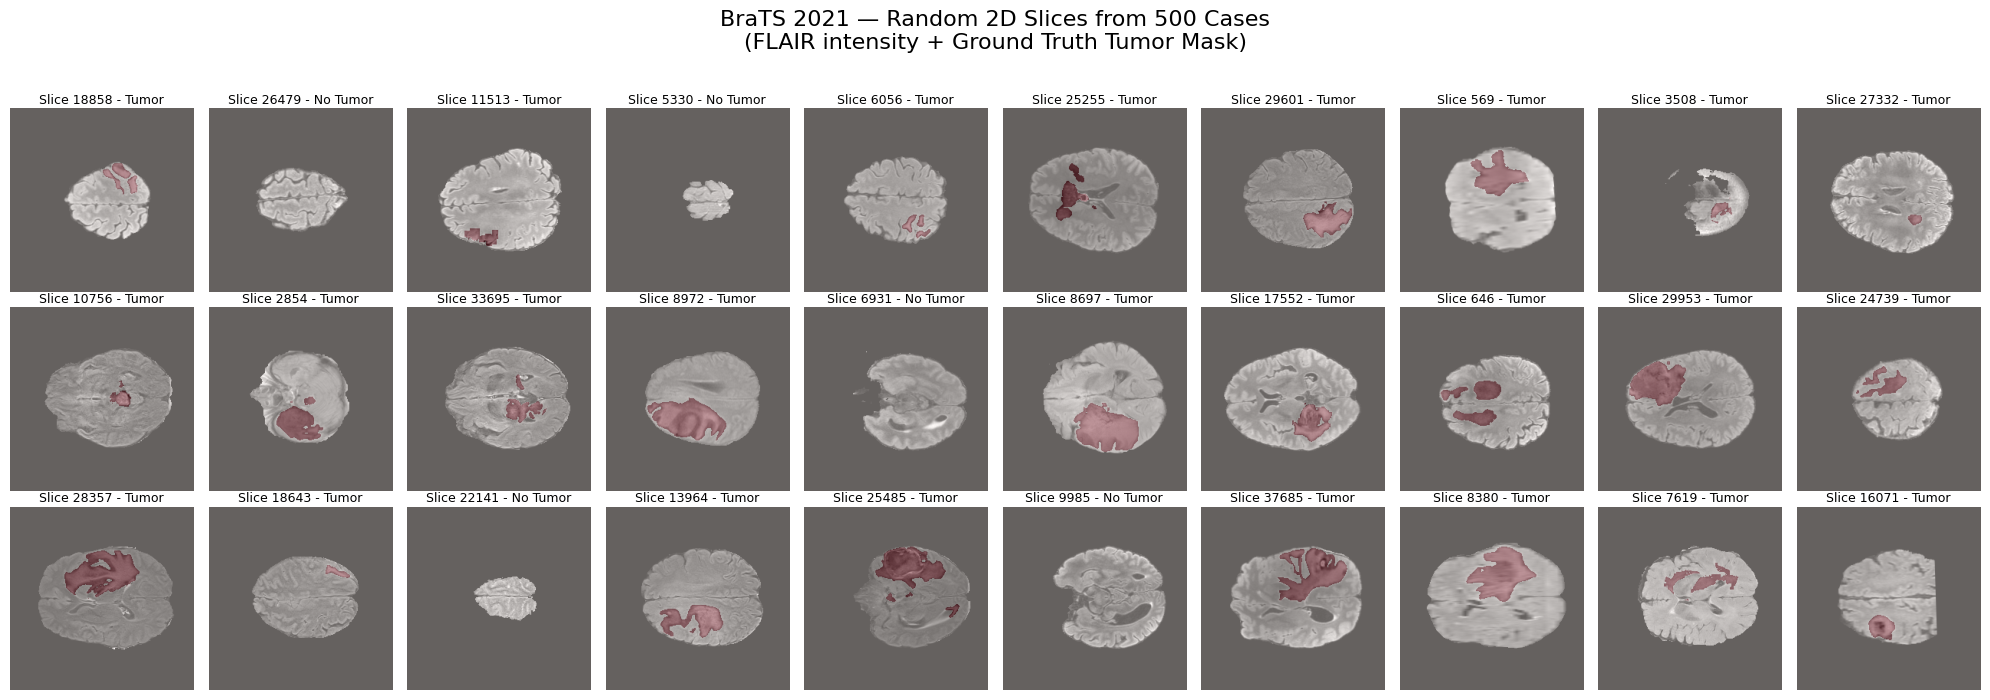

In [7]:
# # Dataset Analysis + Visualization 
# import matplotlib.pyplot as plt
# import random

# from numpy import full

full_ds = torch.utils.data.ConcatDataset([train_ds, val_ds])

print("Dataset Statistics")
print(f"Number of 3D cases used: 500")
print(f"Total 2D slices: {len(full_ds)}")
print(f"Train slices: {len(train_ds)}, Validation slices: {len(val_ds)}")

# Re-calculate tumor vs background 
tumor_slices = 0
bg_slices = 0
for i in range(len(full_ds)):
    mask = full_ds[i][1]
    if mask.sum() > 0:
        tumor_slices += 1
    else:
        bg_slices += 1

print(f"Slices with tumor: {tumor_slices} ({tumor_slices/len(full_ds)*100:.1f}%)")
print(f"Background-only slices: {bg_slices} ({bg_slices/len(full_ds)*100:.1f}%)")

# Visualization
fig, axs = plt.subplots(3, 10, figsize=(20, 7))
fig.suptitle("BraTS 2021 — Random 2D Slices from 500 Cases\n(FLAIR intensity + Ground Truth Tumor Mask)", fontsize=16, y=1.003)

random_indices = random.sample(range(len(full_ds)), 30)

for i, idx in enumerate(random_indices):
    row = i // 10
    col = i % 10
    
    img_tensor, mask_tensor = full_ds[idx]
    img = img_tensor[0].numpy()    # (240, 240)
    mask = mask_tensor[0].numpy()  # (240, 240)

    axs[row, col].imshow(img, cmap='gray')
    axs[row, col].imshow(mask, cmap='Reds', alpha=0.4)
    
    axs[row, col].set_title(
        f"Slice {idx} - " + ("Tumor" if mask.sum() > 0 else "No Tumor"),
        fontsize=9, pad=4
    )
    axs[row, col].axis('off')


plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.show()

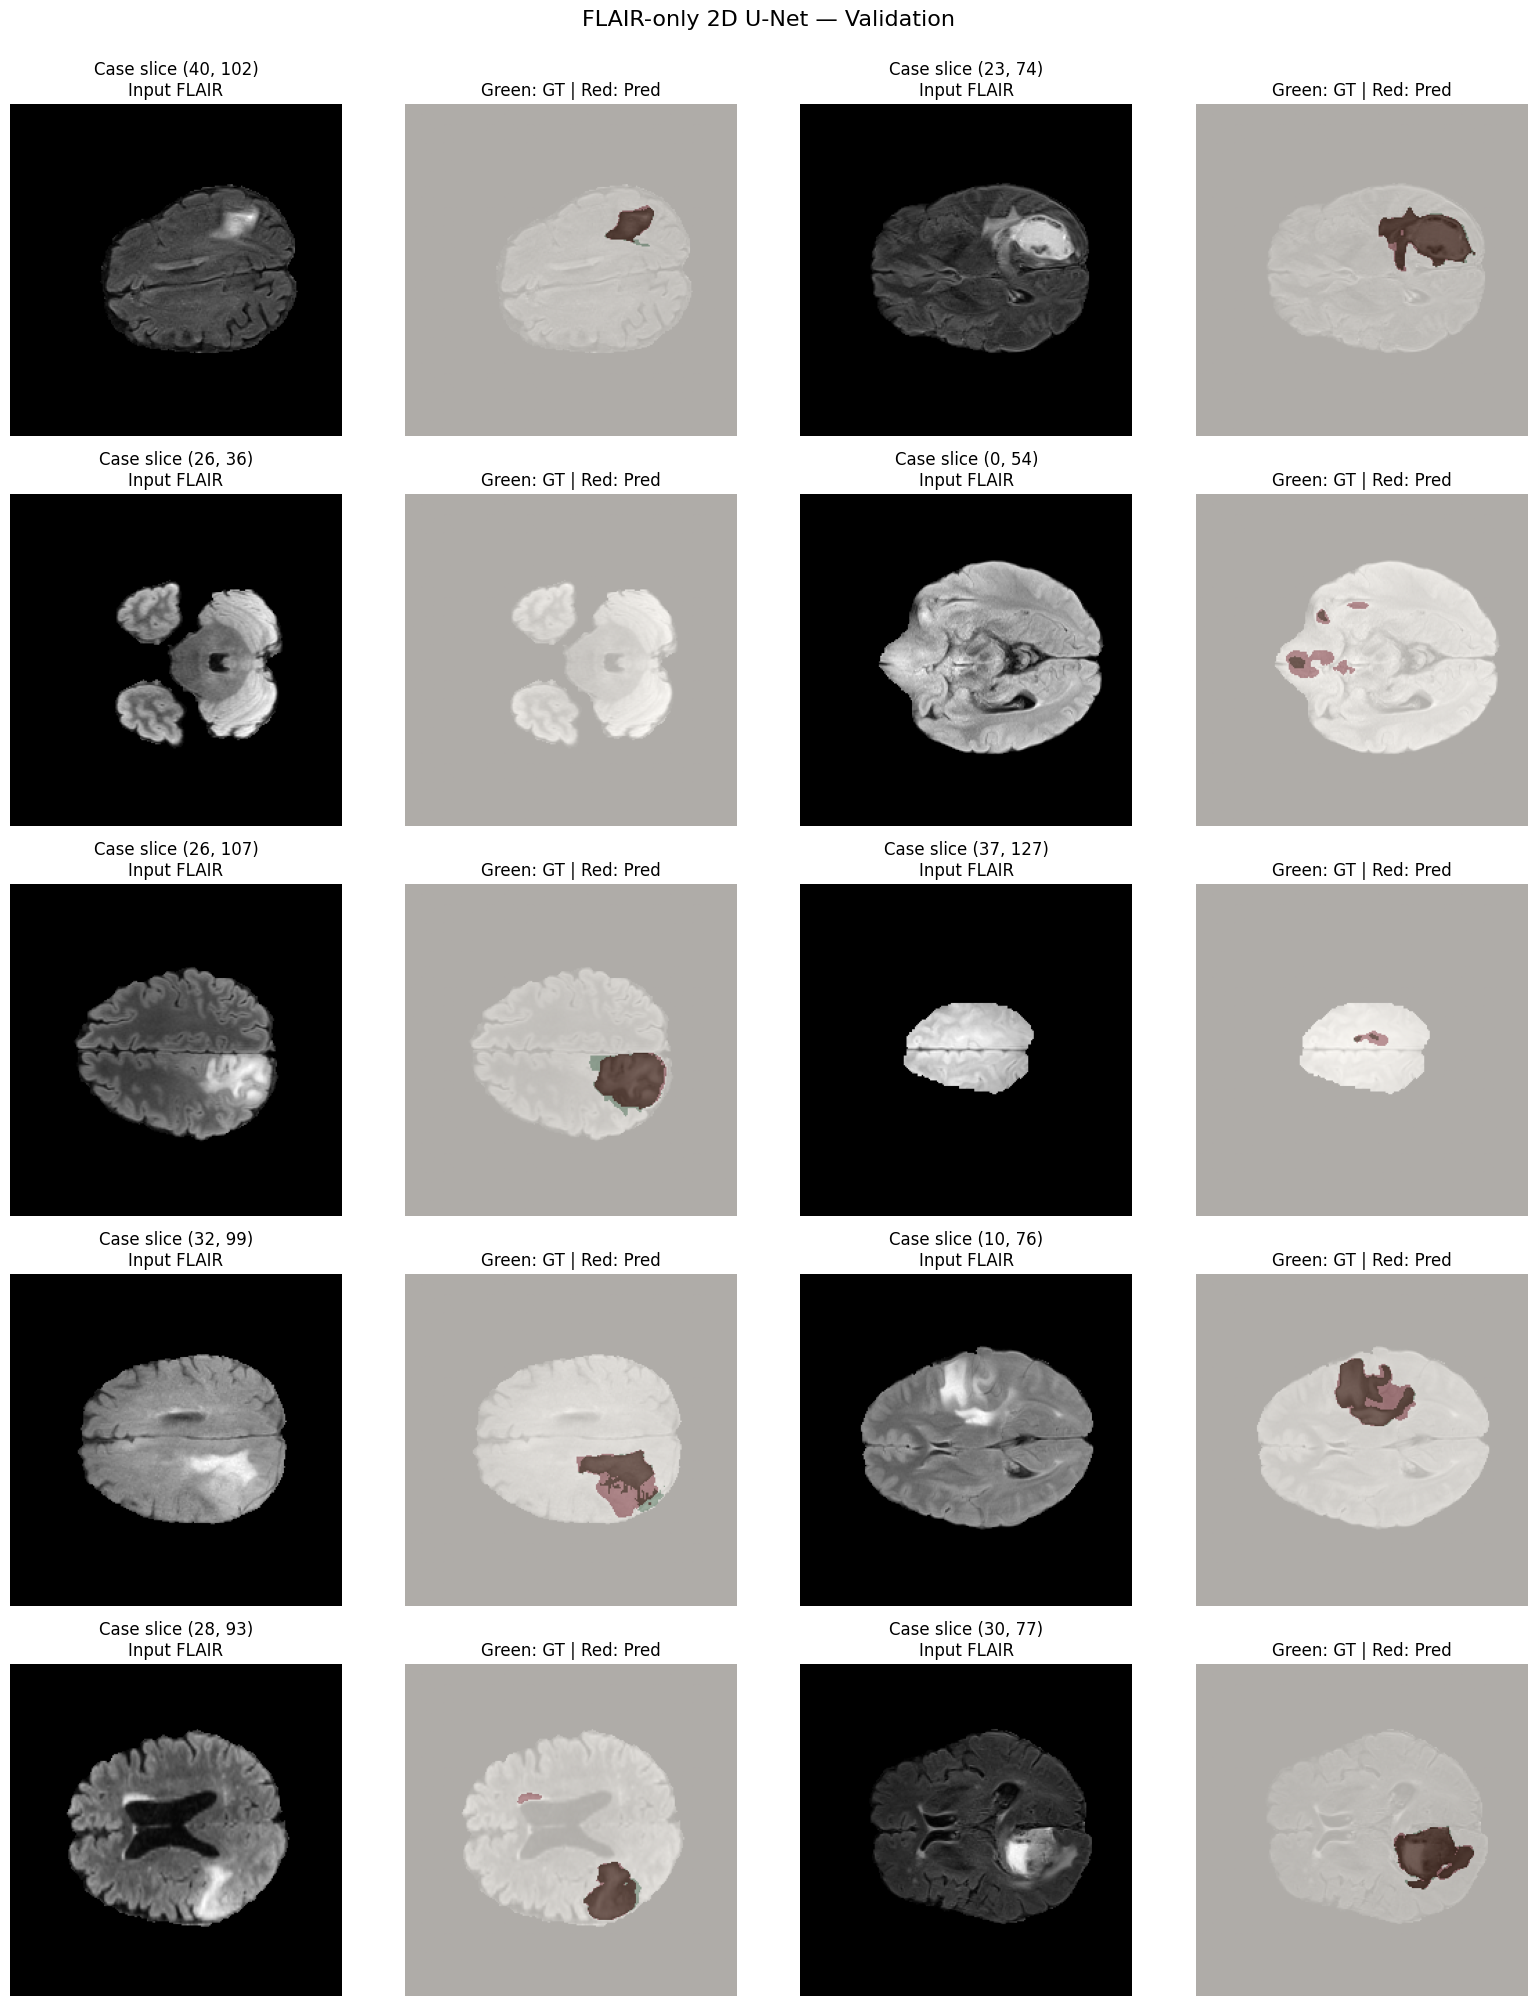

In [13]:
# Visualisation on validation set
model.eval()
model.load_state_dict(torch.load("brats2021_flair_2d_best.pth", map_location=device))
indices = random.sample(range(len(val_ds)), 10)

fig, axs = plt.subplots(5, 4, figsize=(16,20))
fig.suptitle("FLAIR-only 2D U-Net — Validation", fontsize=16, y=1.0005)

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, gt = val_ds[idx]
        pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))[0,0].cpu().numpy()
        pred_bin = (pred > 0.5).astype(np.float32)

        axs[i//2, (i%2)*2].imshow(img[0], cmap='gray')
        axs[i//2, (i%2)*2].set_title(f"Case slice {val_ds.indices[idx]}\nInput FLAIR")
        axs[i//2, (i%2)*2].axis('off')

        ax = axs[i//2, 2*(i%2)+1]
        ax.imshow(img[0], cmap="gray")
        ax.imshow(gt[0], cmap="Greens", alpha=0.5)
        ax.imshow(pred_bin, cmap="Reds", alpha=0.4)
        ax.set_title("Green: GT | Red: Pred"); ax.axis("off")

plt.tight_layout(); plt.show()